# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [346]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
from numpy import hanning as hann

## Functions

In [347]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in the same directory as the notebook.

In [348]:
prefix = "data/"
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), prefix+filename) 

### **Using Soundfile**

In [349]:
x, Fs= sf.read(file_path)

In [350]:
IPython.display.Audio(file_path)

In [351]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

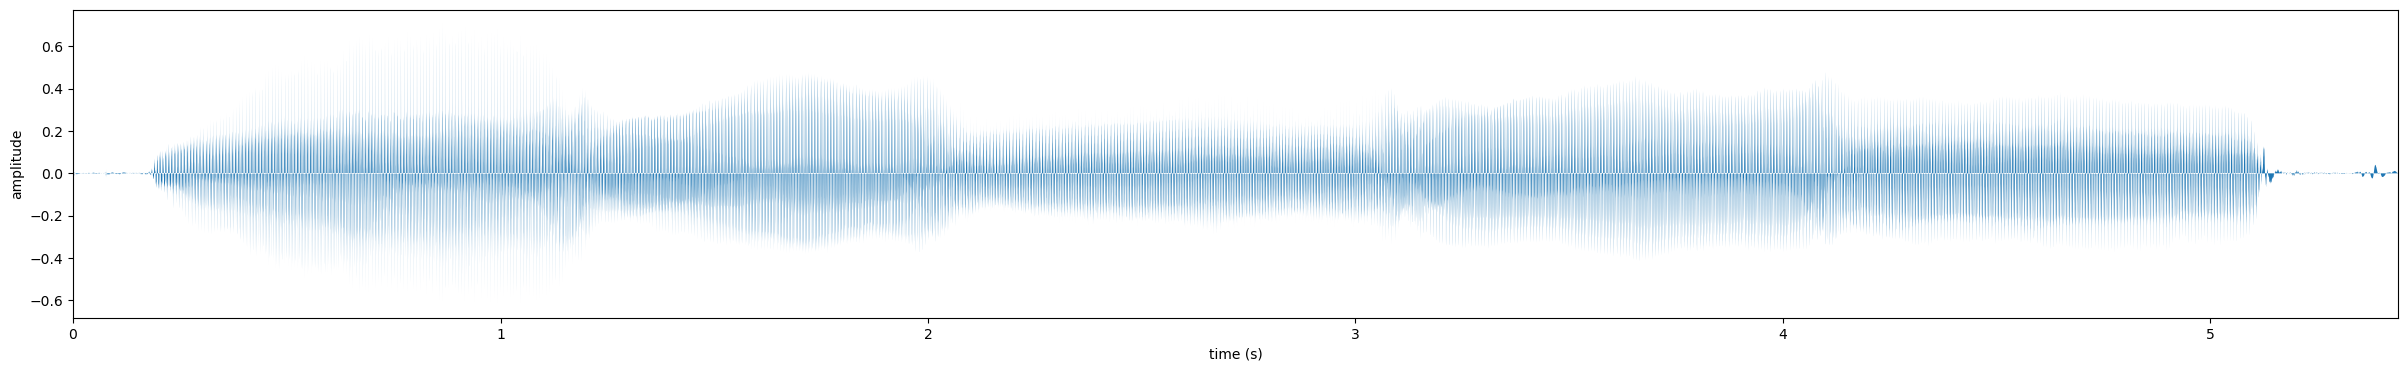

In [352]:
plot_sound(x, times)

In [353]:
def AnalysisPitchMarks(s, Fs):
    A = []
    
    ta_prev = 0
    Pa_prev = Fs // 100
    
    n = 0
    
    while ta_prev + Pa_prev <= len(s):
        start = int(ta_prev)
        end = min(len(s), int(ta_prev + int(2.5 * Pa_prev)))
        x = s[start:end]
        
        P, voiced = period(x, Fs)
        
        ta = ta_prev + P
        A.append([ta, int(voiced), P])
        
        ta_prev = ta
        Pa_prev = P
        n += 1
    
    A = np.array(A).T
    
    return A

def computeB(A):
    return np.array([A[0, :], np.arange(1, A.shape[1] + 1)])

def Synthesis(s, Fs, A, B):
    y = np.zeros(int(B[0, -1] + A[2, -1]))
    
    for k in range(B.shape[1]):
        ts_k = B[0, k]
        n_k = int(B[1, k]) - 1
        
        ta_n_k = A[0, n_k]
        Pa_n_k = A[2, n_k]
        
        start = int(ta_n_k - Pa_n_k)
        end = int(ta_n_k + Pa_n_k + 1)
        
        if start < 0:
            x = s[:end]
            x = np.pad(x, (-start, 0), mode='constant', constant_values=0)
        elif end > len(s):
            x = s[start:]
            x = np.pad(x, (0, end - len(s)), mode='constant', constant_values=0)
        else:
            x = s[start:end]
        
        window = hann(len(x))
        x_windowed = x * window
        
        overlap_start = int(ts_k - Pa_n_k)
        overlap_end = int(ts_k + Pa_n_k + 1)

        if overlap_start >= 0 and overlap_end <= len(y) and len(x_windowed) > 0:
            y[overlap_start:overlap_end] += x_windowed
        else:
            print(f"Skipping invalid overlap: start={overlap_start}, end={overlap_end}, segment length={len(x_windowed)}")
    
    return y

def ChangeTimeScale(alpha, A, Fs):
    B = np.zeros((2, A.shape[1]), dtype=int)
    
    B[0, 0] = 1 
    B[1, 0] = 1
    n_k = 1 
    
    for k in range(1, A.shape[1]): 
        ts_k = B[0, k - 1] + A[2, int(round(n_k))-1]
        B[0, k] = ts_k
        
        n_k = n_k + 1 / alpha 
        
        B[1, k] = int(round(n_k))
    
    return B

def ChangePitchScale(beta, A, Fs):
    B = np.zeros((2, A.shape[1]), dtype=int)  
    
    B[0, 0] = 1  
    n_k = 1  
    
    for k in range(1, A.shape[1]): 
        voiced = A[1, int(n_k) - 1]  
        Pa_n_k = A[2, int(n_k) - 1]  
        
        if voiced:
            scale_k = 1 / beta  
        else:
            scale_k = 1 
        
        ts_k = B[0, k - 1] + scale_k * Pa_n_k
        B[0, k] = int(round(ts_k)) 
        
        n_k = n_k + scale_k
        B[1, k] = int(round(n_k))  
    
    return B


Skipping invalid overlap: start=-136, end=139, segment length=275
59964 30781


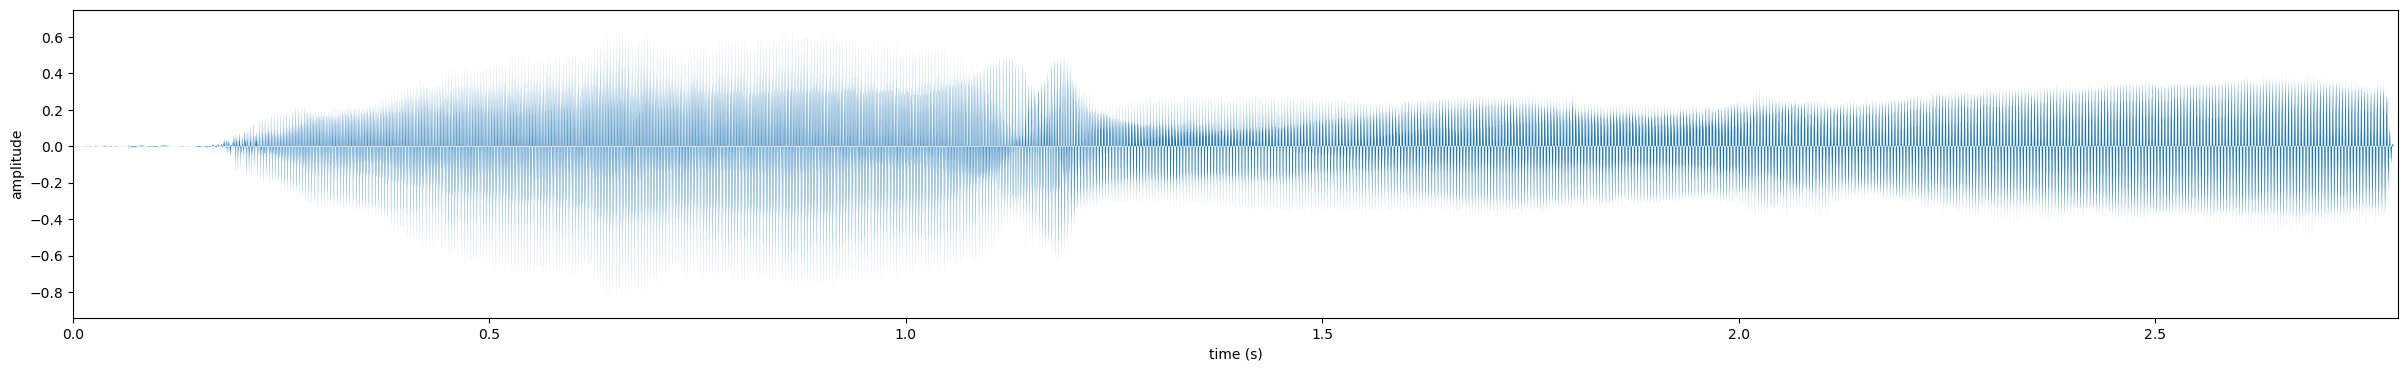

In [354]:
A = AnalysisPitchMarks(x,Fs)
B = ChangePitchScale(2,A,Fs)
y = Synthesis(x, Fs, A, B)
print(len(x),len(y))
plot_sound(y, np.arange(len(y))*timestep)
IPython.display.Audio(y, rate=Fs)